# Example 2: Real EHR Data

Python Port of PheCAP Algorithm

Replicate the process in main.R (see, also, https://celehs.github.io/PheCAP/articles/example2.html).

In [1]:
import sys

sys.path.append('../src')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pyphecap.plotting import plot_roc_curves
from pyphecap.predict import predict_phenotype, predict_probabilities, validate_phenotyping_model
from pyphecap.training import train_phenotyping_model
from pyphecap.feature_extraction import run_feature_extraction
from pyphecap.phecap_data import add_validation_column, Data
from pyphecap.surrogate import Surrogates, Surrogate

In [3]:
np.random.seed(42)

In [4]:
ehr_data = pd.read_csv('../data/ehr_data.csv')  # read sample data output from R
ehr_data.shape

(10000, 590)

In [5]:
# gold standard
ehr_data[~pd.isnull(ehr_data.label)]['label'].value_counts()

1.0    119
0.0     62
Name: label, dtype: int64

In [6]:
add_validation_column(ehr_data)
data = Data(
    ehr_data,
    'healthcare_utilization',
    'label',
    'validation',
)

In [7]:
surrogates = Surrogates(
    Surrogate("main_ICD"),
    Surrogate("main_NLP"),
    Surrogate("main_ICD", "main_NLP"),
)

In [8]:
selected_features = run_feature_extraction(data, surrogates)
selected_features

['main_ICD',
 'main_NLP',
 'NLP6',
 'NLP56',
 'NLP160',
 'NLP161',
 'NLP306',
 'NLP309',
 'NLP403',
 'NLP536',
 'NLP564']

In [9]:
coefficients, train_roc_auc, split_roc_auc = train_phenotyping_model(data, surrogates, selected_features)
coefficients, train_roc_auc[0], split_roc_auc[0]

([('intercept', 0.8333582958126389),
  ('main_ICD', 0.02142645314350241),
  ('main_NLP', 0.220731674300153),
  ('main_ICD__main_NLP', -0.04541811456860259),
  ('healthcare_utilization', -0.14066784019444828),
  ('NLP161', -0.02530781125801814),
  ('NLP564', -0.07854878609497179),
  ('NLP403', 0.028310415074859367),
  ('NLP56', 0.0020623449181112084),
  ('NLP309', -0.024323734225588516),
  ('NLP160', -0.002336054843942158),
  ('NLP6', -0.008909180263690954),
  ('NLP536', 0.0765065537252179),
  ('NLP306', 0.02307694242501946)],
 0.8865800865800866,
 0.8088636363636363)

In [10]:
valid_roc_auc = validate_phenotyping_model(data, surrogates, coefficients, selected_features)
valid_roc_auc[0]

0.9573724668064291

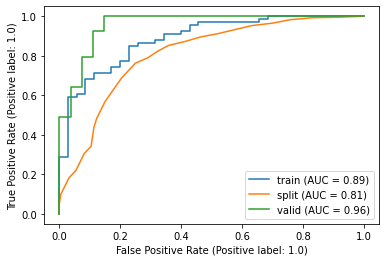

In [11]:
plot_roc_curves(train_roc_auc, split_roc_auc, valid_roc_auc)
plt.show()

In [12]:
phenotype = predict_phenotype(data, surrogates, coefficients, selected_features, valid_roc_auc[1])
phenotype.head()

,patient_id,prediction,case_status
0,1,0.321266,0
1,2,1.280409,1
2,3,0.279455,0
3,4,0.317695,0
4,5,0.505364,0
